In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Configuración opcional
pd.set_option('display.max_columns', None)

# Cargar datos
df = pd.read_excel("Truck Cycle Information for shovel.xlsx")
print(f"Forma del dataset: {df.shape}")
df.head()

# Filtrar solo los ciclos de la pala P&H 4100XPC y material Ore o Waste
df = df[(df['Secondary Machine Class Name'] == 'P&H 4100XPC') & 
        (df['Material Group'].isin(['Ore', 'Waste']))].copy()

# Calcular productividad por ciclo
# Calcular productividad por ciclo en ton/hora
df['Productividad_avg'] = (df['Payload_Q'] / df['Completed Cycle Duration']) * 60


# Ver algunas filas
print(df[['Payload_Q', 'Completed Cycle Duration', 'Productividad_avg']].head())

# LIMPIEZA
# Revisar valores nulos
print(df.isnull().sum())

# Quitar filas con valores nulos en las variables clave
df.dropna(subset=['Payload_Q', 'Completed Cycle Duration', 'Productividad_avg'], inplace=True)

# Quitar filas con duración <= 0
df = df[df['Completed Cycle Duration'] > 0]

print(f"Dataset después de limpieza: {df.shape}")

#  Estadísticas descriptivas de productividad
print("\n Estadísticas de Productividad (ton/hora):")
print(df['Productividad_avg'].describe())

Forma del dataset: (97718, 25)
   Payload_Q  Completed Cycle Duration  Productividad_avg
0        352                     25.34         833.464878
1        355                     27.26         781.364637
2        365                     46.82         467.748825
3        349                     68.64         305.069930
4        322                     30.56         632.198953
OID                                    0
Cycle OID                              0
Date                                   0
Month                                  0
Year                                   0
Secondary Machine Name                 0
Secondary Machine Class Name           0
Material Name                          0
Material Group                         0
Cycle Duration                         0
Completed Cycle Duration Min           0
Loading Duration (min)                 0
Travelling Empty Duration (min)        0
Queuing At Source Duration (min)       0
Spotting At Source Duration (min)      0
Wait F

In [73]:
# Filtrar solo los ciclos con la pala deseada
df_ph = df[df['Secondary Machine Class Name'] == 'P&H 4100XPC']

print(f"Total de ciclos con P&H 4100XPC: {df_ph.shape[0]}")

# Calcular estadísticas básicas para Completed Cycle Duration
q1 = df_ph['Completed Cycle Duration'].quantile(0.25)
q3 = df_ph['Completed Cycle Duration'].quantile(0.75)
iqr = q3 - q1

# Definir límites para outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1: {q1:.2f}")
print(f"Q3: {q3:.2f}")
print(f"IQR: {iqr:.2f}")
print(f"Límite inferior: {lower_bound:.2f}")
print(f"Límite superior: {upper_bound:.2f}")

# Contar outliers
outliers_bajos = df_ph[df_ph['Completed Cycle Duration'] < lower_bound].shape[0]
outliers_altos = df_ph[df_ph['Completed Cycle Duration'] > upper_bound].shape[0]

print(f"\nOutliers por debajo de {lower_bound:.2f}: {outliers_bajos}")
print(f"Outliers por encima de {upper_bound:.2f}: {outliers_altos}")


Total de ciclos con P&H 4100XPC: 82212
Q1: 26.11
Q3: 39.04
IQR: 12.93
Límite inferior: 6.71
Límite superior: 58.44

Outliers por debajo de 6.71: 1822
Outliers por encima de 58.44: 1486


In [74]:
# Eliminar outliers
df_ph_clean = df_ph[
    (df_ph['Completed Cycle Duration'] >= lower_bound) &
    (df_ph['Completed Cycle Duration'] <= upper_bound)
]

print(f"Original: {df_ph.shape[0]} ciclos")
print(f"Sin outliers: {df_ph_clean.shape[0]} ciclos")
print(f"Eliminados: {df_ph.shape[0] - df_ph_clean.shape[0]} ciclos")

Original: 82212 ciclos
Sin outliers: 78904 ciclos
Eliminados: 3308 ciclos


C:\Users\lperez10\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


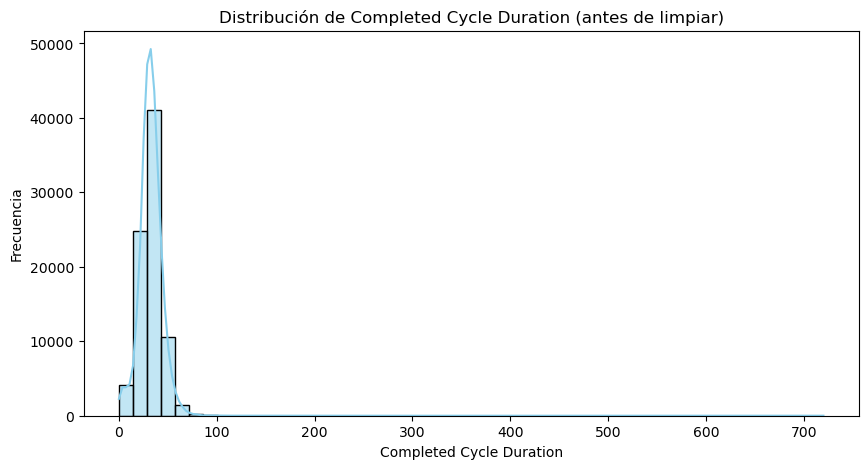

C:\Users\lperez10\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


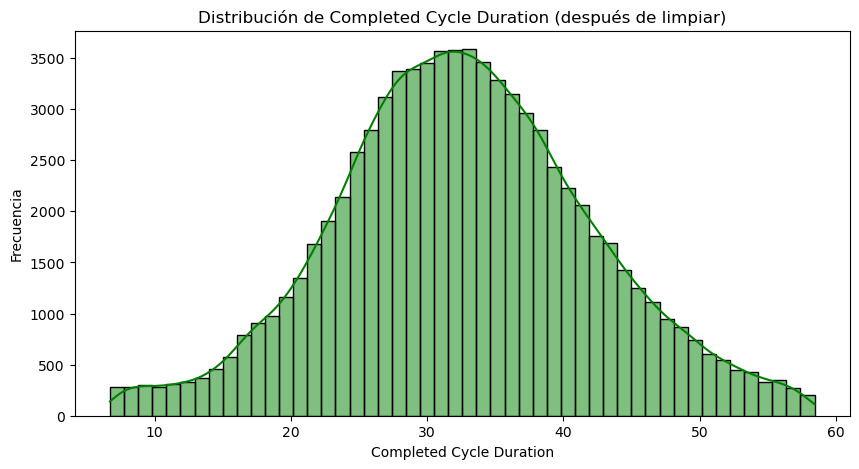

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Antes de limpiar
plt.figure(figsize=(10, 5))
sns.histplot(df_ph['Completed Cycle Duration'], bins=50, kde=True, color='skyblue')
plt.title('Distribución de Completed Cycle Duration (antes de limpiar)')
plt.xlabel('Completed Cycle Duration')
plt.ylabel('Frecuencia')
plt.show()

# Después de limpiar
plt.figure(figsize=(10, 5))
sns.histplot(df_ph_clean['Completed Cycle Duration'], bins=50, kde=True, color='green')
plt.title('Distribución de Completed Cycle Duration (después de limpiar)')
plt.xlabel('Completed Cycle Duration')
plt.ylabel('Frecuencia')
plt.show()


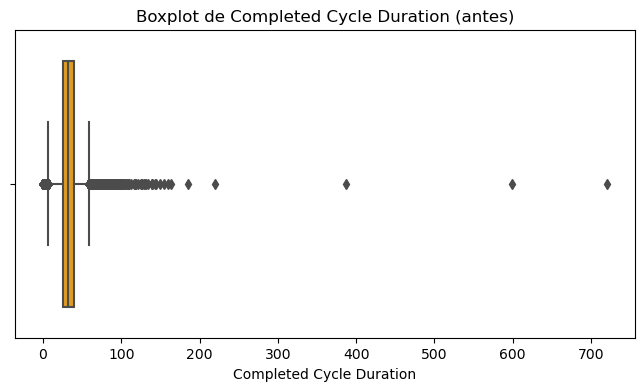

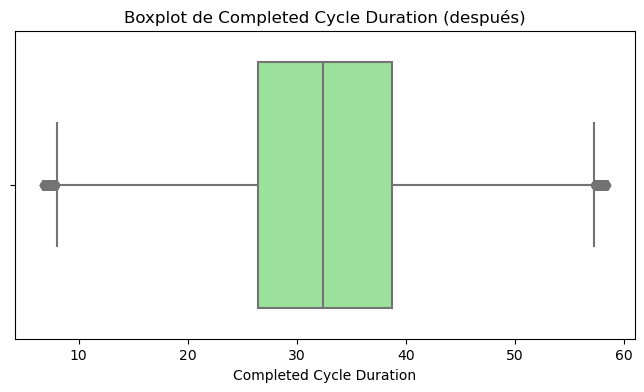

In [76]:
# Antes
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_ph['Completed Cycle Duration'], color='orange')
plt.title('Boxplot de Completed Cycle Duration (antes)')
plt.show()

# Después
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_ph_clean['Completed Cycle Duration'], color='lightgreen')
plt.title('Boxplot de Completed Cycle Duration (después)')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split

# Variables predictoras y variable objetivo
X = df[['Payload_Q', 'Completed Cycle Duration']]
y = df['Productividad_avg']

# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Regresión Lineal
R²: 0.006
RMSE: 10371.75
MAE: 536.47


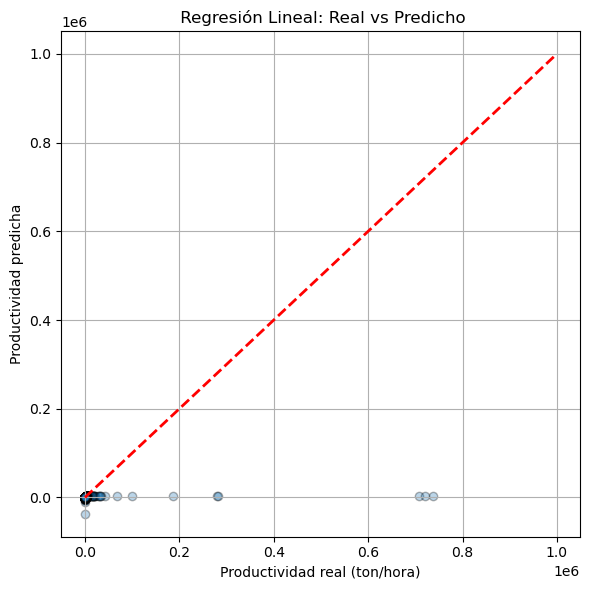

In [78]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#REGRESION LINEAL

# Inicializar modelo
modelo_lr = LinearRegression()

# Entrenar modelo
modelo_lr.fit(X_train, y_train)

# Predicción sobre test
y_pred_lr = modelo_lr.predict(X_test)

# Evaluación del modelo
print("Regresión Lineal")
print(f"R²: {r2_score(y_test, y_pred_lr):.3f}")

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"RMSE: {rmse_lr:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.2f}")


#VISUALIZAR
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)  # Línea de referencia
plt.xlabel('Productividad real (ton/hora)')
plt.ylabel('Productividad predicha')
plt.title(' Regresión Lineal: Real vs Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()

Regresión Random Forest
R²: 0.998
RMSE: 461.23
MAE: 9.99


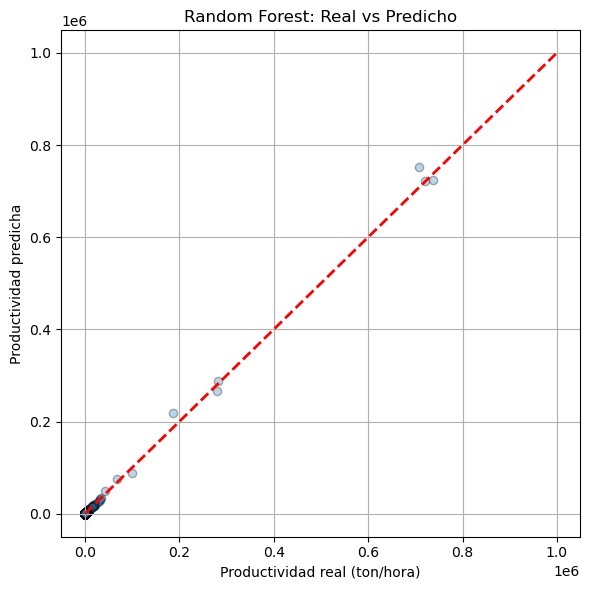

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

#RANDOM FOREST 

# Entrenar modelo
modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicción
y_pred_rf = modelo_rf.predict(X_test)

# Evaluación
print("Regresión Random Forest")
print(f"R²: {r2_score(y_test, y_pred_rf):.3f}")
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Productividad real (ton/hora)')
plt.ylabel('Productividad predicha')
plt.title('Random Forest: Real vs Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()

Gradient Boosting Regressor
R²: 0.999
RMSE: 250.81
MAE: 21.05


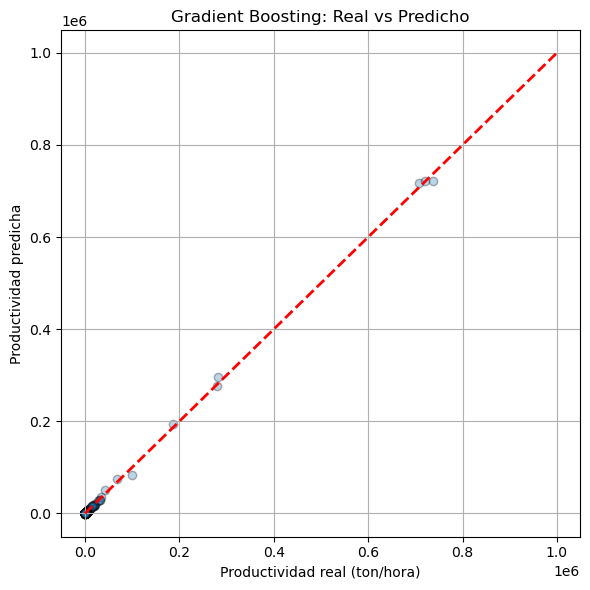

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

#GRADIENT BOOSTING
# Entrenar el modelo
modelo_gb = GradientBoostingRegressor(random_state=42)
modelo_gb.fit(X_train, y_train)

# Predicción
y_pred_gb = modelo_gb.predict(X_test)

# Evaluación
print("Gradient Boosting Regressor")
print(f"R²: {r2_score(y_test, y_pred_gb):.3f}")
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f"RMSE: {rmse_gb:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_gb, alpha=0.3, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Productividad real (ton/hora)')
plt.ylabel('Productividad predicha')
plt.title('Gradient Boosting: Real vs Predicho')
plt.grid(True)
plt.tight_layout()
plt.show()